In [344]:
# Imported Libraries...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit

In [25]:
######## For animation purpose....

from IPython import display 
from IPython.display import HTML
import matplotlib.animation as animation

In [59]:
####### Energy function..
@njit
def deltaE(S0, Sn, J, H):

    '''Energy difference for a spin flip'''
    
    return 2 * S0 * (H + J * Sn)

In [212]:
########## Ising function...
@njit
def ising(n=20, equib = 1000, nsteps=500000,H=0,J=1,T=1, startwith = 1):

    '''Ising Model Simulator.'''
    
    
    if startwith == 1:
        lattice = np.ones((n,n), dtype = np.int32)
    elif startwith == -1 :
        lattice = np.int32(-1) * np.ones((n,n), dtype = np.int32)
    else :
        lattice = np.random.choice(np.array([1, -1], dtype = np.int32), size=(n, n))
    
    

    trajectory = np.zeros((nsteps, n, n))
    energy = 0
    energies = []
    spins = []
    #print(lattice)
    spin = np.sum(lattice)
    
    for step in range(nsteps):

        i = np.random.randint(n)
        j = np.random.randint(n)

        # Periodic Boundary Condition
        Sn = lattice[(i - 1) % n, j] + lattice[(i + 1) % n, j] + \
             lattice[i, (j - 1) % n] + lattice[i, (j + 1) % n]

        dE = deltaE(lattice[i, j], Sn, J, H)
        trajectory[step] = lattice
        if dE < 0 or np.random.random() < np.exp(-dE/T):
            lattice[i, j] = -lattice[i, j]
            energy += dE
            energies.append(energy)
            #trajectory.append(lattice)
         # Note that the spin is collected at every step
            spin += 2*lattice[i, j]
            
        spins.append(spin)
        #if step % 100 == 0:
            #trajectory.append(lattice)
    return trajectory, energies, spins
    

In [246]:
dt = 75
n = 25
T = np.linspace(0.1, 10.0, dt);

In [247]:
######## Configurations started from all negative ones

negative_spin_list = []

for temp in T:
    spins = ising(n = n, nsteps = 100000, T = temp, J = 1, H = 0.0, startwith = -1)[2]
    negative_spin_list.append(spins)

In [248]:
######## Configurations started from all positive ones

positive_spin_list = []

for temp in T:
    spins = ising(n = n, nsteps = 100000, T = temp, J = 1, H = 0.0, startwith = 1)[2]
    positive_spin_list.append(spins)

In [249]:
#plt.plot(np.array(spin_list[49])/400)

(0.0, 6.0)

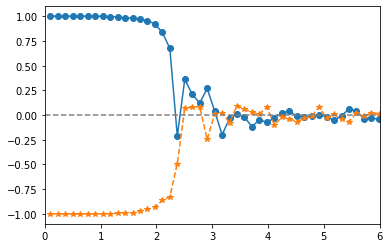

In [256]:
plt.plot(T, np.array([np.mean((positive_spin_list)[i][-10000:]) 
                      for i in range(len(positive_spin_list))])/n**2, marker = "o")
plt.plot(T, np.array([np.mean((negative_spin_list)[i][-10000:]) 
                      for i in range(len(negative_spin_list))])/n**2, marker = "*", ls = "--",)
plt.axhline(y = 0, ls = "--", c = "gray")
plt.xlim([0,6])

In [264]:
#all_spin = np.concatenate([np.array(positive_spin_list).ravel(), np.array(negative_spin_list).ravel()])
#sns.kdeplot(all_spin/n**2)

In [398]:
def getSpin(h = 0.0):
    poslist = []
    neglist = []
    for i in range(50):
        poslist.append(ising(n = n, nsteps = 100000, T = 1.5, J = 1, H = h, startwith = 0)[2])
    for i in range(50):
        neglist.append(ising(n = n, nsteps = 100000, T = 1.5, J = 1, H = h, startwith = 0)[2])
    return poslist, neglist

In [399]:
def getDF(poslist, neglist):
    val1 = np.concatenate([neglist[i][-50000:] for i in range(len(neglist))])/n**2
    val2 = np.concatenate([poslist[i][-50000:] for i in range(len(poslist))])/n**2
    np.concatenate([val1, val2])
    vals , bins = np.histogram(np.concatenate([val1, val2]),bins = 50)
    bin_center = (bins[1:] + bins[:-1])/2.0
    s = pd.Series(np.log(vals))
    bins = pd.Series(bin_center)
    df = pd.DataFrame({"bins":bins, "p(x)":s})
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

In [401]:
poslist, neglist = getSpin(h = 0.0)
df1 = getDF(poslist, neglist)
poslist, neglist = getSpin(h = 0.1)
df2 = getDF(poslist, neglist)
poslist, neglist = getSpin(h = 0.2)
df3 = getDF(poslist, neglist)

/tmp/ipykernel_1681735/272713168.py:7: RuntimeWarning: divide by zero encountered in log
  s = pd.Series(np.log(vals))


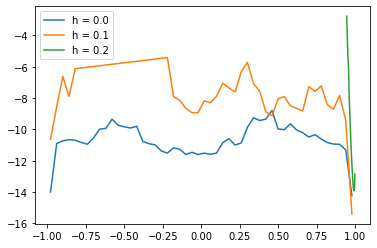

In [403]:
#plt.plot(bin_center, -np.log(vals))
plt.plot(df1.bins, -df1['p(x)'], label = "h = 0.0")
plt.plot(df2.bins, -df2['p(x)'], label = "h = 0.1")
plt.plot(df3.bins, -df3['p(x)'], label = "h = 0.2" )
plt.legend()

## Visualizing phase transitions

In [391]:
T = 1.0
trajectory, energies, spins = ising(n=n, nsteps = 50000, T=T,J = 1, H = 1.0, startwith = -1)

Text(0, 0.5, '<m>')

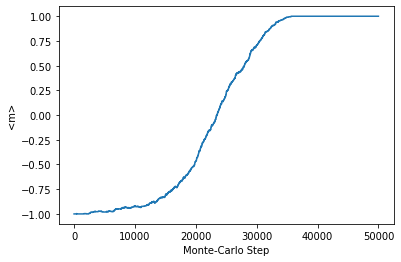

In [405]:
nspins = np.array(spins) / n ** 2
plt.plot(range(len(spins))[:50000], nspins[:50000], label = 'T = 0.5'.format(T))
plt.xlabel("Monte-Carlo Step")
plt.ylabel("<m>")

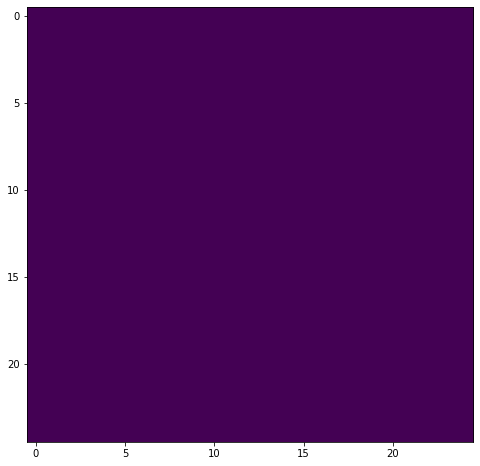

In [396]:
fps = 60

snapshots = trajectory[:50000:10]

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )
frames = len(snapshots)
a = snapshots[0]
im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1)

def animate_func(i):
    if i % (frames//100) == 0:
        print( '.', end ='' )

    im.set_array(snapshots[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(snapshots),
                               interval = 1000 / fps, # in ms
                               )

#anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

#print('Done!')

In [397]:
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()     

.....................................................................................................

## Task 
Your task is to write a code to determine the size of the largest cluster available at that instant.. size of the yellow patch(say)..